In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Define the base directory and paths for the dataset
base_dir = "/content/drive/MyDrive/archive/AI_for_Art_Restoration_2"
damaged_path = os.path.join(base_dir, "paired_dataset_art", "damaged")
undamaged_path = os.path.join(base_dir, "paired_dataset_art", "undamaged")

# Check if the directories exist
if not os.path.exists(damaged_path):
    raise FileNotFoundError(f"The directory '{damaged_path}' does not exist.")
if not os.path.exists(undamaged_path):
    raise FileNotFoundError(f"The directory '{undamaged_path}' does not exist.")


In [ ]:
# ---------- Match filenames (before ↔ after) ----------
damaged_files = [f for f in os.listdir(damaged_path) if "before" in f.lower()]
undamaged_files = [f for f in os.listdir(undamaged_path) if "after" in f.lower()]

# Build a matching dict: match base name without before/after
def get_base_name(filename):
    return filename.lower().replace("before", "").replace("after", "").replace("_", "").replace("-", "").replace(".png", "").strip()

damaged_map = {get_base_name(f): f for f in damaged_files}
undamaged_map = {get_base_name(f): f for f in undamaged_files}

common_keys = list(set(damaged_map.keys()) & set(undamaged_map.keys()))
print(f"✅ Matched {len(common_keys)} before–after image pairs.")


✅ Matched 111 before–after image pairs.


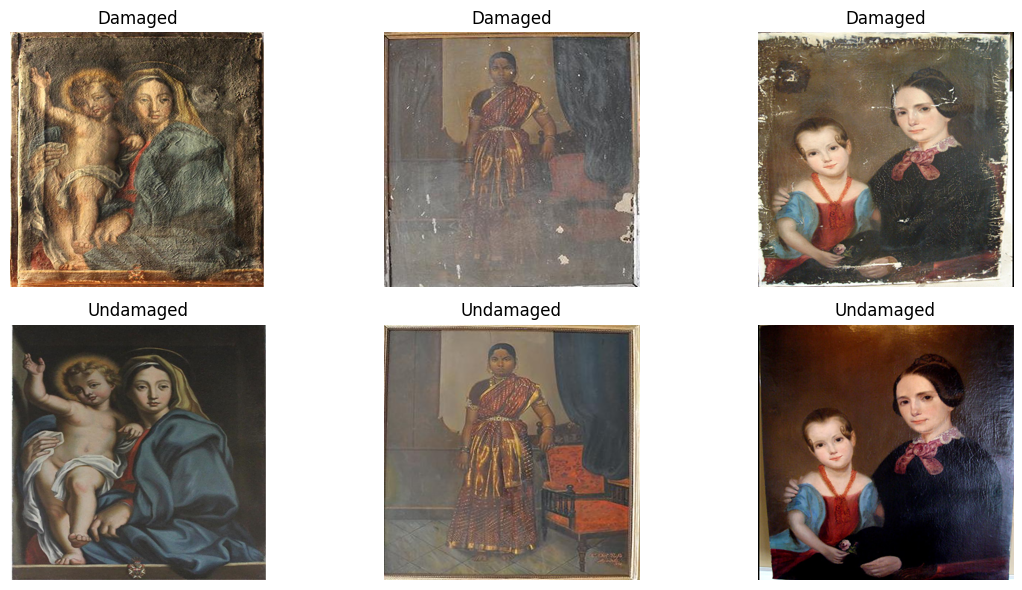

In [ ]:
# ---------- Visualize 3 Sample Pairs ----------
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
img_size = (256, 256)

for i in range(3):
    key = common_keys[i]

    damaged_img = Image.open(os.path.join(damaged_path, damaged_map[key])).convert("RGB").resize(img_size)
    undamaged_img = Image.open(os.path.join(undamaged_path, undamaged_map[key])).convert("RGB").resize(img_size)

    axes[0, i].imshow(damaged_img)
    axes[0, i].set_title("Damaged")
    axes[0, i].axis('off')

    axes[1, i].imshow(undamaged_img)
    axes[1, i].set_title("Undamaged")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [5]:
# ---------- Prepare arrays ----------
X = []  # Damaged images (input)
Y = []  # Undamaged images (target)

print(f"Processing {len(common_keys)} matched image pairs...")

for key in tqdm(common_keys):
    try:
        damaged_img = Image.open(os.path.join(damaged_path, damaged_map[key])).convert("RGB").resize(img_size)
        undamaged_img = Image.open(os.path.join(undamaged_path, undamaged_map[key])).convert("RGB").resize(img_size)

        X.append(np.array(damaged_img) / 255.0)   # Normalize to [0,1]
        Y.append(np.array(undamaged_img) / 255.0)
    except Exception as e:
        print(f"⚠️ Error processing {key}: {e}")

# Convert lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# ---------- Output shapes ----------
print("✅ Input (damaged) shape:", X.shape)
print("✅ Target (undamaged) shape:", Y.shape)


Processing 111 matched image pairs...


100%|██████████| 111/111 [00:37<00:00,  2.99it/s]

✅ Input (damaged) shape: (111, 256, 256, 3)
✅ Target (undamaged) shape: (111, 256, 256, 3)


In [6]:
# ---------- Model Definition ----------
def build_restoration_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)  # 128x128

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)  # 64x64

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2))(x)  # 32x32

    # Decoder
    x = UpSampling2D((2, 2))(encoded)  # 64x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)  # 128x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)  # 256x256
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, decoded)
    return model

# ---------- Compile ----------
model = build_restoration_model()
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,379 (2.83 MB)

 Trainable params: 741,379 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ---------- Split the data ----------
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

print("Train shape:", X_train.shape, Y_train.shape)
print("Val shape:", X_val.shape, Y_val.shape)


Train shape: (99, 256, 256, 3) (99, 256, 256, 3)
Val shape: (12, 256, 256, 3) (12, 256, 256, 3)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - loss: 0.0713 - mae: 0.2325 - val_loss: 0.0729 - val_mae: 0.2332
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 8s/step - loss: 0.0665 - mae: 0.2188 - val_loss: 0.0745 - val_mae: 0.2394
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - loss: 0.0667 - mae: 0.2241 - val_loss: 0.0724 - val_mae: 0.2365
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - loss: 0.0627 - mae: 0.2157 - val_loss: 0.0709 - val_mae: 0.2325
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - loss: 0.0541 - mae: 0.1991 - val_loss: 0.0653 - val_mae: 0.2208
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - loss: 0.0516 - mae: 0.1918 - val_loss: 0.0548 - val_mae: 0.1934
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - loss: 0.0472 - mae: 0.1788 - val_loss: 0.0566 - val_mae: 0.1901
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - loss: 0.0409 - mae: 0.1590 - val_loss: 0.0662 - val_mae: 0.2043
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - loss: 0.042

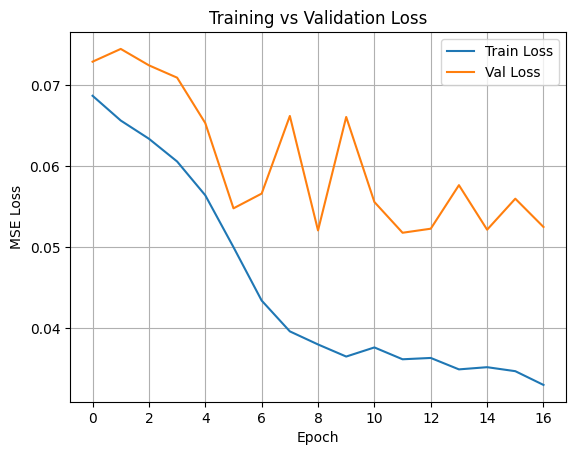

In [8]:
# ---------- Callbacks ----------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ---------- Train ----------
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stop]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


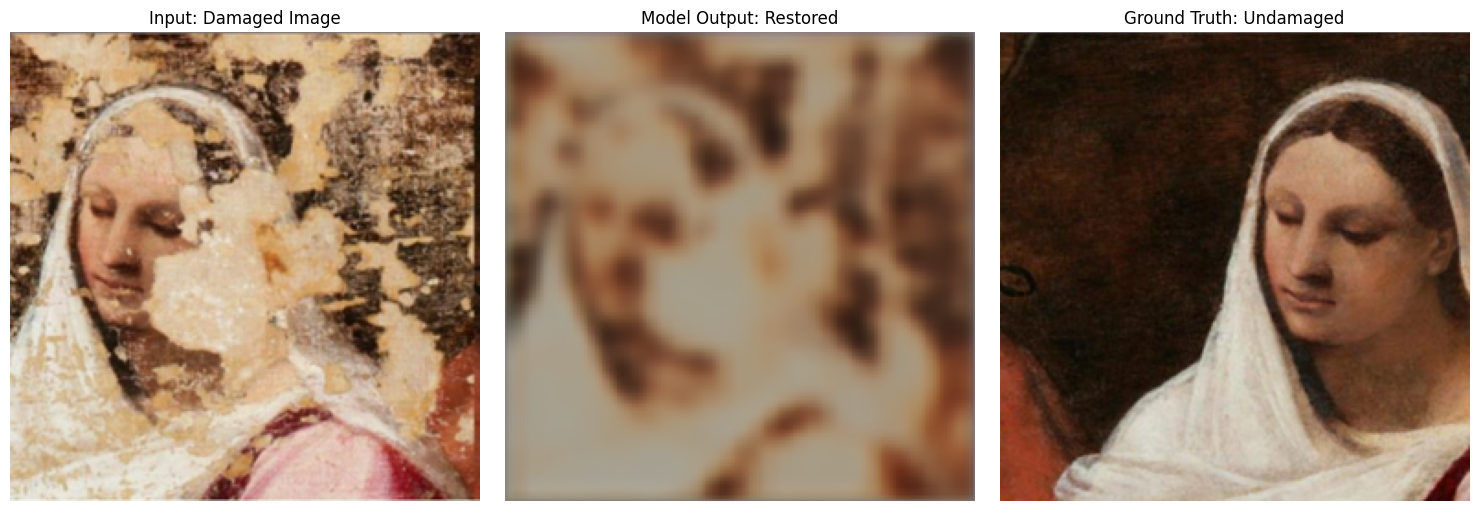

In [27]:
# ---------- Pick a random sample ----------
idx = random.randint(0, X_val.shape[0] - 1)

damaged = X_val[idx]
true_restored = Y_val[idx]

# Predict the restoration
predicted_restored = model.predict(np.expand_dims(damaged, axis=0))[0]

# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(damaged)
axes[0].set_title("Input: Damaged Image")
axes[0].axis('off')

axes[1].imshow(predicted_restored)
axes[1].set_title("Model Output: Restored")
axes[1].axis('off')

axes[2].imshow(true_restored)
axes[2].set_title("Ground Truth: Undamaged")
axes[2].axis('off')

plt.tight_layout()
plt.show()
